In [25]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# cube computation supported by main memory

In [26]:
#required libraries
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import csv
from sklearn import preprocessing
import re

In [27]:
#loading data
df = pd.read_csv('/content/drive/MyDrive/Copy of master.csv')

In [28]:
#changing into required datatype
df = df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'})
df['gdp_for_year ($)'] = df['gdp_for_year ($)'].apply(lambda x:float(x.replace(',','')))

**Data Exploration**

In [29]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [30]:
df.describe(include=['object','int','float'])

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
count,27820,27820.000000,27820,27820,27820.000000,2.782000e+04,27820.000000,27820,8364.000000,2.782000e+04,27820.000000,27820
unique,101,NaN,2,6,NaN,NaN,NaN,2321,NaN,NaN,NaN,6
top,Mauritius,NaN,male,15-24 years,NaN,NaN,NaN,Albania1987,NaN,NaN,NaN,Generation X
freq,382,NaN,13910,4642,NaN,NaN,NaN,12,NaN,NaN,NaN,6408
mean,NaN,2001.258375,NaN,NaN,242.574407,1.844794e+06,12.816097,NaN,0.776601,4.455810e+11,16866.464414,NaN
std,NaN,8.469055,NaN,NaN,902.047917,3.911779e+06,18.961511,NaN,0.093367,1.453610e+12,18887.576472,NaN
min,NaN,1985.000000,NaN,NaN,0.000000,2.780000e+02,0.000000,NaN,0.483000,4.691962e+07,251.000000,NaN
25%,NaN,1995.000000,NaN,NaN,3.000000,9.749850e+04,0.920000,NaN,0.713000,8.985353e+09,3447.000000,NaN
50%,NaN,2002.000000,NaN,NaN,25.000000,4.301500e+05,5.990000,NaN,0.779000,4.811469e+10,9372.000000,NaN
75%,NaN,2008.000000,NaN,NaN,131.000000,1.486143e+06,16.620000,NaN,0.855000,2.602024e+11,24874.000000,NaN


In [31]:
for i in df.columns:
  print(i,len(df[i].unique()))
  if(len(df[i].unique()) < 100):
    print(df[i].unique())

country 101
year 32
[1987 1988 1989 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 1985 1986 1990 1991 2012 2013
 2014 2015 2011 2016]
sex 2
['male' 'female']
age 6
['15-24 years' '35-54 years' '75+ years' '25-34 years' '55-74 years'
 '5-14 years']
suicides_no 2084
population 25564
suicides/100k pop 5298
country-year 2321
HDI for year 306
gdp_for_year ($) 2321
gdp_per_capita ($) 2233
generation 6
['Generation X' 'Silent' 'G.I. Generation' 'Boomers' 'Millenials'
 'Generation Z']


## Preprocessing

In [32]:
#removing the columns that we felt not required for the task
df = df.drop(columns=['suicides/100k pop','country-year','gdp_for_year ($)'])

In [33]:
#defined a concept hierarchy for the columns possible
concept_hierarchy={
    'gdp_per_capita ($)':{
         'low':[0,1005],
        'lower-middle':[1005,3955],
        'upper-middle':[3955,12235],
        'high':[12235,126353],
    },
    'population':{
        'low-sized':[0,11000],
        'medium-sized':[11000,1100000],
        'large-sized':[1100000,1000000000],
    },
    'suicides_no':{
       'low':[0,5],
       'medium':[5,95],
       'high':[95,25000] 
    },
    'HDI for year':{
        'low':[0, 0.600],
        'medium':[0.600,0.700],
        'high':[0.700,0.800],
        'very_high':[0.800,1.1],
    }
}

In [34]:
#handling missing values
df['HDI for year']= df['HDI for year'].interpolate(method="polynomial",order=2)
df['HDI for year']= df['HDI for year'].fillna(0.59)

**generalising over the concept hierarchy we defined**

In [35]:
def up_onLevel(row,concept_hierarchy,attribute):
  level_dict = concept_hierarchy[attribute]
  for key,val in level_dict.items():
      if(row >=val[0] and row < val[1]):
        return key

In [36]:
def generalize(df):

  cls = list(df.columns)

  attribute_removal_threshold = 102

  for attribute in cls:

          # remove attribute if the distinct values greater than a specific threshold
    if(len(list((df[attribute].unique()))) > attribute_removal_threshold ):
      if(attribute in concept_hierarchy):
        df[attribute] = df[attribute].apply(lambda x:up_onLevel(x,concept_hierarchy,attribute))
      else:
        df = df.drop([attribute], axis=1)
      
    else:
      if(attribute in concept_hierarchy):
        df[attribute] = df[attribute].apply(lambda x:up_onLevel(x,concept_hierarchy,attribute))
   
  return df

In [37]:
df = generalize(df)

In [38]:
df.head()

,country,year,sex,age,suicides_no,population,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,medium,medium-sized,low,low,Generation X
1,Albania,1987,male,35-54 years,medium,medium-sized,low,low,Silent
2,Albania,1987,female,15-24 years,medium,medium-sized,low,low,Generation X
3,Albania,1987,male,75+ years,low,medium-sized,low,low,G.I. Generation
4,Albania,1987,male,25-34 years,medium,medium-sized,low,low,Boomers


In [39]:
#changing the string values into integers
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({le.transform([cl])[0]:cl})

    return res

In [40]:
integerMapping = {}
label_encoder = preprocessing.LabelEncoder()
df_cls = list(df.columns)
for i in range(len(df.columns)):
  df[df_cls[i]] = label_encoder.fit_transform(df[df_cls[i]])
  integerMapping[i] = get_integer_mapping(label_encoder)


In [41]:
df.head()

,country,year,sex,age,suicides_no,population,HDI for year,gdp_per_capita ($),generation
0,0,2,1,0,2,2,1,1,2
1,0,2,1,2,2,2,1,1,5
2,0,2,0,0,2,2,1,1,2
3,0,2,1,5,1,2,1,1,1
4,0,2,1,1,2,2,1,1,0


## Algorithm

we followed the below algorithm

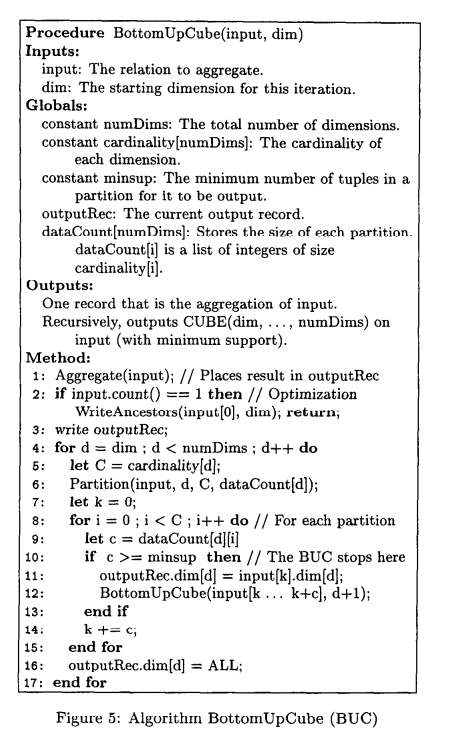

In [42]:
# collect data in a numpy array
data = df.to_numpy()
n_tuples = data.shape[0]
n_dim = data.shape[1]
minsup = 1

cardinality = []
for i in range(n_dim):
  unique, counts = np.unique(data[:,i], return_counts=True)
  cardinality.append(len(unique))

output_names = []
output = []

#### calculates nodes of the processing tree

In [43]:
def calculate_name(cd):

  output_names.append(cd)
  last = 0
  
  if len(cd) == 2:
    last = int(cd[-2])
  else:
    if(cd[len(cd) - 3] == ' '):
      last = int(cd[len(cd)-2])
    else:
      last = int(cd[len(cd)-3:len(cd)-1])
  
  if (last + 1 == n_dim):
    return
  else:
    for i in range(last+1,n_dim):
      calculate_name(cd+str(i)+" ")

#### calculates nodes of the processing tree

In [1]:
def init_output():

  output_names.append("ALL")
  for i in range(n_dim):
    calculate_name(str(i)+" ")

  # resize the number of data cuboids to 2^n_dimensions
  # output.resize(output_names.size());
  for i in range(len(output_names)):
    output.append([])

In [46]:
def output_indexof(path):

  for i in range(len(output_names)):
    if(output_names[i] == path):
      return i
  
  return 0

#### Initiates the output data structure

#### Optimization : When the data size becomes 'one' the output of descendants is stored instead of getting into the BUC function again

In [47]:
def write_ancestors_one(path,row):

  list_of_dims_in_path = re.findall(r'\S+', path)

  l = []
  for i in list_of_dims_in_path:
    l.append(row[int(i)])
  l.append(1)

  output_index = output_indexof(path)
  output[output_index].append(l)

  last = 0
  
  if len(path) == 2:
    last = int(path[-2])
  else:
    if(path[len(path) - 3] == ' '):
      last = int(path[len(path)-2])
    else:
      last = int(path[len(path)-3:len(path)-1])
  
  if (last + 1 == n_dim):
    return
  else:
    for i in range(last+1,n_dim):
      write_ancestors_one(path+str(i)+" ",row)

In [45]:
def partition(data,dim,cardinality):

  n = data.shape[0]

  if(n == 0):
    return [],[]
  
  counts = [0 for i in range(cardinality)]

  for i in data[:,dim]:
    counts[i]+=1
  cnt = []
  cnt.append(counts[0])
  for i in range(1,len(counts)):
      cnt.append(cnt[i-1]+counts[i])

  cum_count = cnt.copy()

  sorted_data = [[0 for j in range(n_dim)] for i in range(n)]
  i=n-1
  while i>=0:
    sorted_data[cnt[data[i][dim]]-1]=data[i]
    cnt[data[i][dim]]-=1
    i=i-1
  
  sorted_data = np.array(sorted_data)
  return sorted_data, cum_count, counts


In [3]:

def buc(data,dim,data_dim_size,path):


  if (data_dim_size == 1):
    write_ancestors_one(path, data[0])
    return


    #  write the count to the output record 
  if ((data_dim_size > 0) and (len(path) > 0)):
    list_of_dims_in_path = re.findall(r'\S+', path)

    l = []
    for i in list_of_dims_in_path:
      l.append(data[0][int(i)])
    l.append(data_dim_size)

    output_index = output_indexof(path)
    output[output_index].append(l)

  for i in range(dim,n_dim):

    cardinality_data = cardinality[i]  #finding the cardinality of a particular dimension
    sorted_data, cum_count, data_count = partition(data,i,cardinality_data)  #partioning the data and getting the sorted data

    for j in range(cardinality_data):
      c = data_count[j]
      if(c >= minsup):
        start = 0
        if(j>0):
          start = cum_count[j-1]
        end = cum_count[j]
        size = end-start
        if(size == 0):
          continue

        buc(sorted_data[start:end,:],i+1,size,path+str(i)+" ")


In [49]:
def display_output_summary():
  for i in range(len(output_names)):
    if(len(output[i]) > 0):
      for j in range(n_dim):
        if str(j) in output_names[i]:
          print(j,end=" ")
        else:
          print("*",end=" ")

      print(":", len(output[i]))

In [50]:
def print_cuboid(path):
  index = output_indexof(path)
  cnt = 0
  list_of_dims_in_path = re.findall(r'\S+', path)
  h =[]
  for x in list_of_dims_in_path:
    h.append(int(x))
  ind = 0
  d={}
  for i in h:
    d[i] = ind
    ind+=1

  for l in output[index]:
    
    for j in range(n_dim):
      if j not in h:
        print("*",end=" ")
      else:
        print(integerMapping[j][l[d[j]]],end=" ")
    print(l[-1])
    cnt+=l[-1]
  print(cnt)

In [51]:
init_output()
buc(data,0,data.shape[0],"")
display_output_summary()


0 * * * * * * * * : 101
0 1 * * * * * * * : 2321
0 1 2 * * * * * * : 4642
0 1 2 3 * * * * * : 27820
0 1 2 3 4 * * * * : 27820
0 1 2 3 4 5 * * * : 27820
0 1 2 3 4 5 6 * * : 27820
0 1 2 3 4 5 6 7 * : 27820
0 1 2 3 4 5 6 7 8 : 27820
0 1 2 3 4 5 6 * 8 : 27820
0 1 2 3 4 5 * 7 * : 27820
0 1 2 3 4 5 * 7 8 : 27820
0 1 2 3 4 5 * * 8 : 27820
0 1 2 3 4 * 6 * * : 27820
0 1 2 3 4 * 6 7 * : 27820
0 1 2 3 4 * 6 7 8 : 27820
0 1 2 3 4 * 6 * 8 : 27820
0 1 2 3 4 * * 7 * : 27820
0 1 2 3 4 * * 7 8 : 27820
0 1 2 3 4 * * * 8 : 27820
0 1 2 3 * 5 * * * : 27820
0 1 2 3 * 5 6 * * : 27820
0 1 2 3 * 5 6 7 * : 27820
0 1 2 3 * 5 6 7 8 : 27820
0 1 2 3 * 5 6 * 8 : 27820
0 1 2 3 * 5 * 7 * : 27820
0 1 2 3 * 5 * 7 8 : 27820
0 1 2 3 * 5 * * 8 : 27820
0 1 2 3 * * 6 * * : 27820
0 1 2 3 * * 6 7 * : 27820
0 1 2 3 * * 6 7 8 : 27820
0 1 2 3 * * 6 * 8 : 27820
0 1 2 3 * * * 7 * : 27820
0 1 2 3 * * * 7 8 : 27820
0 1 2 3 * * * * 8 : 27820
0 1 2 * 4 * * * * : 9391
0 1 2 * 4 5 * * * : 11712
0 1 2 * 4 5 6 * * : 11857
0 1 2 * 4 5 6 7 *

In [52]:
print_cuboid("1 2 7 8 ")

* 1985 female * * * * high Boomers 7
* 1985 female * * * * high G.I. Generation 14
* 1985 female * * * * high Generation X 14
* 1985 female * * * * high Silent 7
* 1985 female * * * * low Boomers 3
* 1985 female * * * * low G.I. Generation 6
* 1985 female * * * * low Generation X 6
* 1985 female * * * * low Silent 3
* 1985 female * * * * lower-middle Boomers 21
* 1985 female * * * * lower-middle G.I. Generation 42
* 1985 female * * * * lower-middle Generation X 42
* 1985 female * * * * lower-middle Silent 21
* 1985 female * * * * upper-middle Boomers 17
* 1985 female * * * * upper-middle G.I. Generation 34
* 1985 female * * * * upper-middle Generation X 34
* 1985 female * * * * upper-middle Silent 17
* 1985 male * * * * high Boomers 7
* 1985 male * * * * high G.I. Generation 14
* 1985 male * * * * high Generation X 14
* 1985 male * * * * high Silent 7
* 1985 male * * * * low Boomers 3
* 1985 male * * * * low G.I. Generation 6
* 1985 male * * * * low Generation X 6
* 1985 male * * * * l

# main memory is not supporting the whole dataset

In [ ]:
#required libraries
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import csv
from sklearn import preprocessing
import re

In [ ]:
#loading data
df = pd.read_csv('/content/drive/MyDrive/Copy of master.csv')

In [ ]:
#changing into required datatype
df = df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'})
df['gdp_for_year ($)'] = df['gdp_for_year ($)'].apply(lambda x:float(x.replace(',','')))

**Data Exploration**

In [ ]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [ ]:
df.describe(include=['object','int','float'])

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
count,27820,27820.000000,27820,27820,27820.000000,2.782000e+04,27820.000000,27820,8364.000000,2.782000e+04,27820.000000,27820
unique,101,NaN,2,6,NaN,NaN,NaN,2321,NaN,NaN,NaN,6
top,Mauritius,NaN,male,15-24 years,NaN,NaN,NaN,Albania1987,NaN,NaN,NaN,Generation X
freq,382,NaN,13910,4642,NaN,NaN,NaN,12,NaN,NaN,NaN,6408
mean,NaN,2001.258375,NaN,NaN,242.574407,1.844794e+06,12.816097,NaN,0.776601,4.455810e+11,16866.464414,NaN
std,NaN,8.469055,NaN,NaN,902.047917,3.911779e+06,18.961511,NaN,0.093367,1.453610e+12,18887.576472,NaN
min,NaN,1985.000000,NaN,NaN,0.000000,2.780000e+02,0.000000,NaN,0.483000,4.691962e+07,251.000000,NaN
25%,NaN,1995.000000,NaN,NaN,3.000000,9.749850e+04,0.920000,NaN,0.713000,8.985353e+09,3447.000000,NaN
50%,NaN,2002.000000,NaN,NaN,25.000000,4.301500e+05,5.990000,NaN,0.779000,4.811469e+10,9372.000000,NaN
75%,NaN,2008.000000,NaN,NaN,131.000000,1.486143e+06,16.620000,NaN,0.855000,2.602024e+11,24874.000000,NaN


In [ ]:
for i in df.columns:
  print(i,len(df[i].unique()))
  if(len(df[i].unique()) < 100):
    print(df[i].unique())

country 101
year 32
[1987 1988 1989 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 1985 1986 1990 1991 2012 2013
 2014 2015 2011 2016]
sex 2
['male' 'female']
age 6
['15-24 years' '35-54 years' '75+ years' '25-34 years' '55-74 years'
 '5-14 years']
suicides_no 2084
population 25564
suicides/100k pop 5298
country-year 2321
HDI for year 306
gdp_for_year ($) 2321
gdp_per_capita ($) 2233
generation 6
['Generation X' 'Silent' 'G.I. Generation' 'Boomers' 'Millenials'
 'Generation Z']


## Preprocessing

In [ ]:
#removing the columns that we felt not required for the task
df = df.drop(columns=['suicides/100k pop','country-year','gdp_for_year ($)'])

In [ ]:
#defined a concept hierarchy for the columns possible
concept_hierarchy={
    'gdp_per_capita ($)':{
         'low':[0,1005],
        'lower-middle':[1005,3955],
        'upper-middle':[3955,12235],
        'high':[12235,126353],
    },
    'population':{
        'low-sized':[0,11000],
        'medium-sized':[11000,1100000],
        'large-sized':[1100000,1000000000],
    },
    'suicides_no':{
       'low':[0,5],
       'medium':[5,95],
       'high':[95,25000] 
    },
    'HDI for year':{
        'low':[0, 0.600],
        'medium':[0.600,0.700],
        'high':[0.700,0.800],
        'very_high':[0.800,1.1],
    }
}

In [ ]:
#handling missing values
df['HDI for year']= df['HDI for year'].interpolate(method="polynomial",order=2)
df['HDI for year']= df['HDI for year'].fillna(0.59)

**generalising over the concept hierarchy we defined**

In [ ]:
def up_onLevel(row,concept_hierarchy,attribute):
  level_dict = concept_hierarchy[attribute]
  for key,val in level_dict.items():
      if(row >=val[0] and row < val[1]):
        return key

In [ ]:
def generalize(df):

  cls = list(df.columns)

  attribute_removal_threshold = 102

  for attribute in cls:

          # remove attribute if the distinct values greater than a specific threshold
    if(len(list((df[attribute].unique()))) > attribute_removal_threshold ):
      if(attribute in concept_hierarchy):
        df[attribute] = df[attribute].apply(lambda x:up_onLevel(x,concept_hierarchy,attribute))
      else:
        df = df.drop([attribute], axis=1)
      
    else:
      if(attribute in concept_hierarchy):
        df[attribute] = df[attribute].apply(lambda x:up_onLevel(x,concept_hierarchy,attribute))
   
  return df

In [ ]:
df = generalize(df)

In [ ]:
df.head()

,country,year,sex,age,suicides_no,population,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,medium,medium-sized,low,low,Generation X
1,Albania,1987,male,35-54 years,medium,medium-sized,low,low,Silent
2,Albania,1987,female,15-24 years,medium,medium-sized,low,low,Generation X
3,Albania,1987,male,75+ years,low,medium-sized,low,low,G.I. Generation
4,Albania,1987,male,25-34 years,medium,medium-sized,low,low,Boomers


In [ ]:
#changing the string values into integers
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({le.transform([cl])[0]:cl})

    return res

In [ ]:
integerMapping = {}
label_encoder = preprocessing.LabelEncoder()
df_cls = list(df.columns)
for i in range(len(df.columns)):
  df[df_cls[i]] = label_encoder.fit_transform(df[df_cls[i]])
  integerMapping[i] = get_integer_mapping(label_encoder)


In [ ]:
df.head()

,country,year,sex,age,suicides_no,population,HDI for year,gdp_per_capita ($),generation
0,0,2,1,0,2,2,1,1,2
1,0,2,1,2,2,2,1,1,5
2,0,2,0,0,2,2,1,1,2
3,0,2,1,5,1,2,1,1,1
4,0,2,1,1,2,2,1,1,0


## BUC algorithm 
### Part B

### Assumption: Even single dimension will not fit into the memory

### Initializing all the required variables

In [ ]:
data = df.to_numpy()        #converting data to numpy array
n_tuples = data.shape[0]
n_dim = data.shape[1]
minsup = 200

memory_size = 10000         # memory size is taken here
no_of_files = int(math.ceil(data.shape[0]/memory_size))  # number of temporary files possible with the gven memory size

output_names = []    #stores the node names of the processing tree
output = []          # stores the aggregated output of each path and for each dimension unique value

### splitting the data into different files where each files stores the rows whose total size will not exceed the memory size

In [ ]:
count_of_rows = 0
path = '/content/drive/MyDrive/DA1 Assignment/Data/'
p = 0

for i in range(0,data.shape[0],memory_size):
  if(i+memory_size > data.shape[0]):
    with open(path+'p'+str(p)+'.npy', 'wb') as f:
      np.save(f, data[i:data.shape[0],:])
      p+=1
  else:
    with open(path+'p'+str(p)+'.npy', 'wb') as f:
      np.save(f, data[i:i+memory_size,:])
      p+=1

In [ ]:
unique_values = [set() for i in range(n_dim)]    #to store the unique values of each dimension

p=0
for i in range(no_of_files):
  with open(path+'p'+str(p)+'.npy', 'rb') as f:
    temp_data = np.load(f,allow_pickle=True)
    for dim in range(n_dim):
      unique_values[dim].update(list(np.unique(temp_data[:,dim])))
  p+=1

cardinality = []                                #stores the unique values of each dimension
for i in unique_values:
  cardinality.append(len(i))

### Required functions

#### calculates nodes of the processing tree

In [ ]:
def calculate_name(cd):

  output_names.append(cd)
  last = 0
  
  if len(cd) == 2:
    last = int(cd[-2])
  else:
    if(cd[len(cd) - 3] == ' '):
      last = int(cd[len(cd)-2])
    else:
      last = int(cd[len(cd)-3:len(cd)-1])
  
  if (last + 1 == n_dim):
    return
  else:
    for i in range(last+1,n_dim):
      calculate_name(cd+str(i)+" ")

#### Initiates the output data structure

In [ ]:
def init_output():

  output_names.append("ALL")
  for i in range(n_dim):
    calculate_name(str(i)+" ")

  # resize the number of data cuboids to 2^n_dimensions
  for i in range(len(output_names)):
    output.append([])

In [ ]:
def output_indexof(path):

  for i in range(len(output_names)):
    if(output_names[i] == path):
      return i
  
  return 0

#### Optimization : When the data size becomes 'one' the output of descendants is stored instead of getting into the BUC function again

In [ ]:
def write_ancestors_one(path,row):

  list_of_dims_in_path = re.findall(r'\S+', path)

  l = []
  for i in list_of_dims_in_path:
    l.append(row[int(i)])
  l.append(1)

  output_index = output_indexof(path)
  output[output_index].append(l)

  last = 0
  
  if len(path) == 2:
    last = int(path[-2])
  else:
    if(path[len(path) - 3] == ' '):
      last = int(path[len(path)-2])
    else:
      last = int(path[len(path)-3:len(path)-1])
  
  if (last + 1 == n_dim):
    return
  else:
    for i in range(last+1,n_dim):
      write_ancestors_one(path+str(i)+" ",row)

### Working of Partition function:


1.   Take the offset of the data i.e startrow and endrow
2.   Go to the required file and get the count of the required dimension unique values
3.  Calculate the cumulative sum of above the count
3.  start from the first unique value of the dimension

    a.  store all the rows belonging to that particular unique value into files (to fit into the memory) by traversing through all the files
4.  Now replace the original files with the above sorted files
5.  Return the above calculated cumulative sum which then later is used to find the index of each unique value of that particular dimension


In [ ]:
def partition(data_st,data_en,dim,cardinality):

  counts = [0 for i in range(cardinality)]
  files_of_dim = [[] for i in range(cardinality)]
  offset_storage = []


  p=0
  data = []
  partition_start = 0
  partition_end = 0
  block_start = 0
  block_end = 0
  sorted_data = []

  block_start_flag = False

  for i in range(no_of_files):

    with open(path+'p'+str(i)+'.npy', 'rb') as f:
      temp_data = np.load(f,allow_pickle=True)


      if( block_start_flag == False and data_st > partition_start+temp_data.shape[0]):
        partition_start+=temp_data.shape[0]
        partition_end+=temp_data.shape[0]

      elif( block_start_flag == False and data_st <= partition_start+temp_data.shape[0]):
        block_start = data_st - partition_start
        block_start_flag = True

      


      if(block_start_flag and data_en <= partition_end+temp_data.shape[0]):
        block_end =  data_en - partition_end

        req_data = temp_data[block_start:block_end,:]

        l = [path+'p'+str(i)+'.npy',block_start,block_end ]
        offset_storage.append(l)


        for row in req_data:             #count the attributes
          counts[row[dim]]+=1
        break

      elif(block_start_flag and data_en > partition_end+temp_data.shape[0]):
        block_end = temp_data.shape[0]
        req_data = temp_data[block_start:block_end,:]

        l = [path+'p'+str(i)+'.npy',block_start,block_end ]
        offset_storage.append(l)

        for row in req_data:             #count the attributes
          counts[row[dim]]+=1

        partition_end+=temp_data.shape[0]
        block_start = 0
  


  sorted_data = []
  cnt = 0
  p=0
  stored_att = []


  for i in range(cardinality):
    for l in offset_storage:

      file_path = l[0]
      st = l[1]
      en = l[2]


      with open(file_path, 'rb') as f:
        temp_data = np.load(f,allow_pickle=True)

      req_data = temp_data[st:en]

      for row in req_data:
        if(row[dim] == i):
          sorted_data.append(row)
          cnt+=1
          if(cnt == memory_size):
              with open(path+str(dim)+str(p)+'.npy', 'a+b') as f:
                np.save(f, np.array(sorted_data))
              
              stored_att.append(path+str(dim)+str(p)+'.npy')
              p+=1
              cnt=0
              sorted_data = []


  if(cnt < memory_size):
    with open(path+str(dim)+str(p)+'.npy', 'a+b') as f:
      np.save(f, np.array(sorted_data))
    stored_att.append(path+str(dim)+str(p)+'.npy')
    sorted_data = []

  dim_files = p+1
  

  
  stored_att = list(set(stored_att))
  stored_att.sort()
  p = 0
  sorted_data = []
  r = 0

  li = 0
  file_path = offset_storage[li][0]
  st = offset_storage[li][1]
  en = offset_storage[li][2]
  cnt = en-st
  li+=1
  while(cnt>0):


    with open(stored_att[r], 'rb') as f:
      temp_data = np.load(f,allow_pickle=True)
      r+=1

    for row in temp_data:
      sorted_data.append(row)
      cnt-=1
      if(cnt == 0):
        with open(path+str(dim)+'0'+str(p)+'.npy', 'a+b') as f:
          np.save(f, np.array(sorted_data))
        
        if(li < len(offset_storage)):
          file_path = offset_storage[li][0]
          st = offset_storage[li][1]
          en = offset_storage[li][2]
          cnt += en-st
          li+=1
        sorted_data = []
        p+=1
    

  dim_zero_files = p
  


  p = 0
  for l in offset_storage:

    file_path = l[0]
    st = l[1]
    en = l[2]
    
    with open(file_path, 'rb') as f:
      temp_data = np.load(f,allow_pickle=True)
    
    with open(path+str(dim)+'0'+str(p)+'.npy', 'rb') as f:
      temp_attr_data = np.load(f,allow_pickle=True)
    p+=1
    
    temp_data[st:en] = temp_attr_data

    with open(file_path, 'wb') as f:
      np.save(f, temp_data)



  for i in range(dim_files):

    try:
      os.remove(path+str(dim)+str(i)+'.npy')
    except:
      print("Error while deleting file : ",path+str(dim)+str(i)+'.npy')
    
  for i in range(dim_zero_files):
      try:
          os.remove(path+str(dim)+'0'+str(i)+'.npy')
      except:
          print("Error while deleting file : ",path+str(dim)+'0'+str(i)+'.npy')

  cnt_cum = []
  cnt_cum.append(counts[0])
  for i in range(1,len(counts)):
      cnt_cum.append(cnt_cum[i-1]+counts[i])

  cum_count = cnt_cum.copy()

  return cum_count, counts


In [ ]:
def get_first_row(data_st,data_en):

  partition_start = 0
  block_start = 0

  for i in range(no_of_files):

    with open(path+'p'+str(i)+'.npy', 'rb') as f:
      temp_data = np.load(f,allow_pickle=True)

      if(data_st > partition_start+temp_data.shape[0]):
        partition_start+=temp_data.shape[0]

      elif(data_st <= partition_start+temp_data.shape[0]):
        block_start = data_st - partition_start
        return temp_data[block_start]

In [2]:

def buc(data_st,data_en,dim,data_dim_size,path):


  if (data_dim_size == 1):

    data = get_first_row(data_st,data_en)
    write_ancestors_one(path, data)
    return

    #  write the count to the output record 
  if ((data_dim_size > 0) and (len(path) > 0)):
    list_of_dims_in_path = re.findall(r'\S+', path)

    l = []
    data = get_first_row(data_st,data_en)

    for i in list_of_dims_in_path:
      l.append(data[int(i)])
    l.append(data_dim_size)

    output_index = output_indexof(path)
    output[output_index].append(l)

  for i in range(dim,n_dim):

    cardinality_data = cardinality[i]  #finding the cardinality of a particular dimension
    cum_count, data_count = partition(data_st,data_en,i,cardinality_data)  #partioning the data and getting the sorted data


    for j in range(cardinality_data):

      c = data_count[j]

      if(c >= minsup):

        start = 0
        if(j>0):
          start = cum_count[j-1]
        end = cum_count[j]
        size = end-start

        if(size == 0):
          continue

        buc(start,end,i+1,size,path+str(i)+" ")


In [ ]:
init_output()

import timeit

start = timeit.default_timer()

buc(0,data.shape[0],0,data.shape[0],"")

stop = timeit.default_timer()

print('Time: ', stop - start)

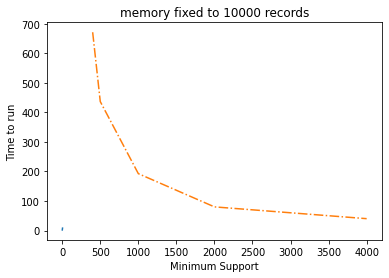

In [ ]:
minimum_support = [400,500,1000,2000,4000]
runtime = [671.4887831759988, 436.6764414399986,  192.56012280999857, 80.01126716400177,40.09369309400063]


plt.plot(minimum_support, runtime, '-.')

plt.xlabel("Minimum Support")
plt.ylabel("Time to run")
plt.title('memory fixed to 10000 records')
plt.show()

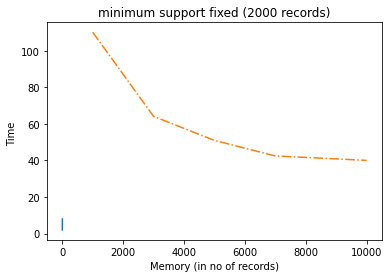

In [ ]:
memory = [1000,3000,5000,7000,10000]
runtime = [110.17948708600002, 64.14942453100002,  50.97261840800002, 42.48251482699999,40.05048853599999]


plt.plot(memory, runtime, '-.')

plt.xlabel("Memory (in no of records)")
plt.ylabel("Time ")
plt.title('minimum support fixed (2000 records)')
plt.show()